In [27]:
from ipywidgets import Image
from ipywidgets import ColorPicker, IntSlider, link, AppLayout, HBox
from ipycanvas import RoughCanvas, hold_canvas

In [28]:
import PIL
from PIL import Image
import numpy as np
import torch
from torch import autocast
from slugify import slugify
from time import time

from diffusers import DDIMScheduler
from diffusion_utils import StableDiffusionImg2ImgPipeline, stable_diffusion_preprocess_image

In [29]:
width = 1000
height = 1000

In [30]:
canvas = RoughCanvas(width=width, height=height, sync_image_data=True)

drawing = False
position = None
shape = []


def on_mouse_down(x, y):
    global drawing
    global position
    global shape

    drawing = True
    position = (x, y)
    shape = [position]


def on_mouse_move(x, y):
    global drawing
    global position
    global shape

    if not drawing:
        return

    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)

        position = (x, y)

    shape.append(position)


def on_mouse_up(x, y):
    global drawing
    global position
    global shape

    drawing = False

    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)
        canvas.fill_polygon(shape)

    shape = []


canvas.on_mouse_down(on_mouse_down)
canvas.on_mouse_move(on_mouse_move)
canvas.on_mouse_up(on_mouse_up)

canvas.stroke_style = "#749cb8"

picker = ColorPicker(description="Color:", value="#749cb8")

link((picker, "value"), (canvas, "stroke_style"))
link((picker, "value"), (canvas, "fill_style"))

HBox((canvas, picker))

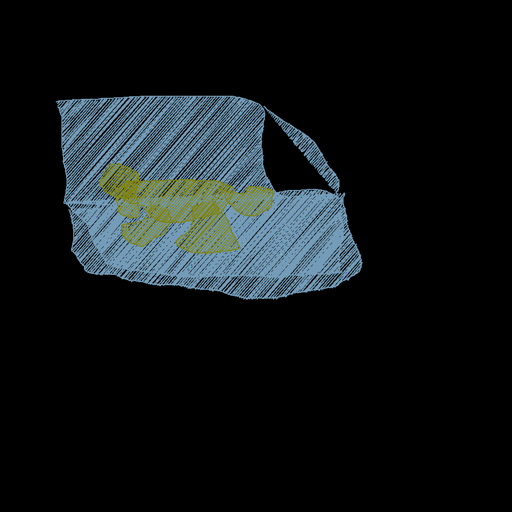

In [31]:
# load image from canvas
canvas_array = canvas.get_image_data()
data = Image.fromarray(canvas_array)

start_image = data.convert('RGB')
start_image = start_image.resize((512, 512)) # tweak this according to your GPU VRAM
start_image.show()


In [32]:
device     = 'cuda'
model_path = 'models/stable-diffusion-v1.4'

scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
model = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    scheduler=scheduler,
    revision='fp16',
    torch_dtype=torch.float16,
).to(device)

In [33]:


#disable nsfw
model.safety_checker = lambda images, **kwargs: (images, False)

# preprocess for Stable Diffusion
start_image_preprocessed = stable_diffusion_preprocess_image(start_image)
start_image_preprocessed.shape

torch.Size([1, 3, 512, 512])

In [34]:
generator = torch.Generator(device=device).manual_seed(42)

0it [00:00, ?it/s]

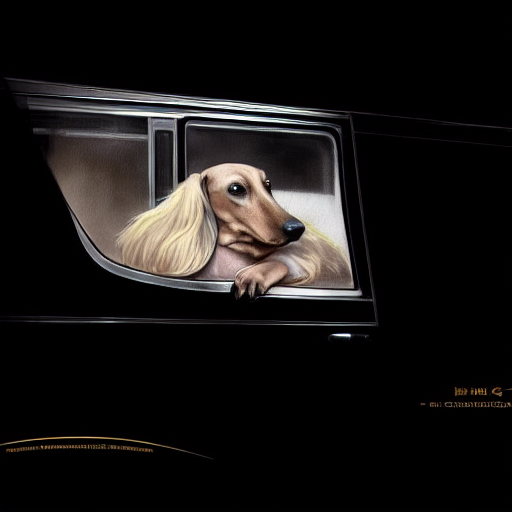

0it [00:00, ?it/s]

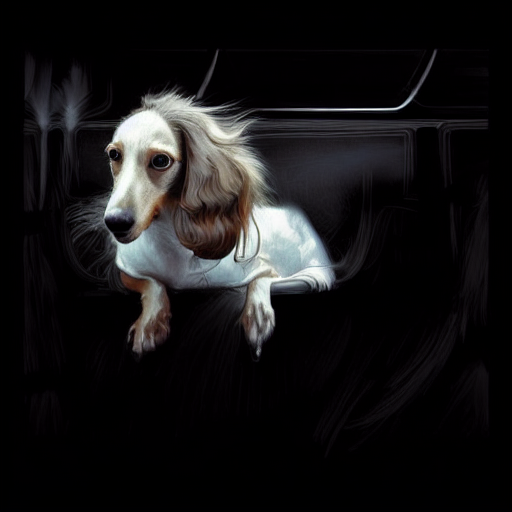

0it [00:00, ?it/s]

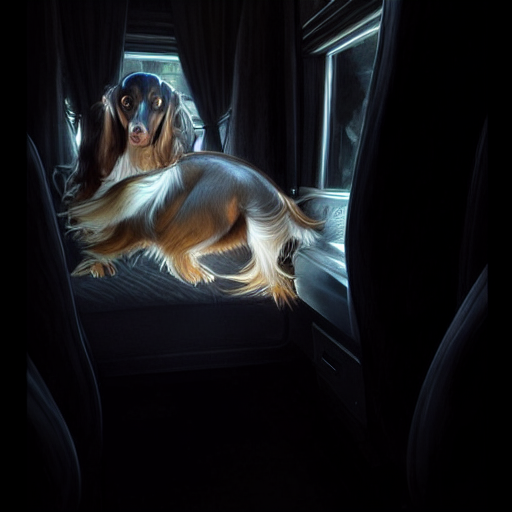

0it [00:00, ?it/s]

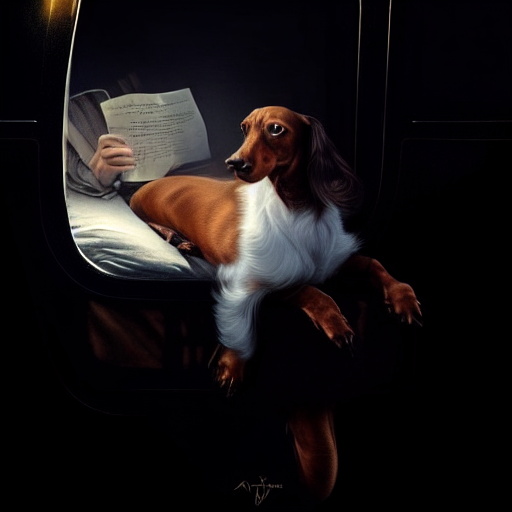

0it [00:00, ?it/s]

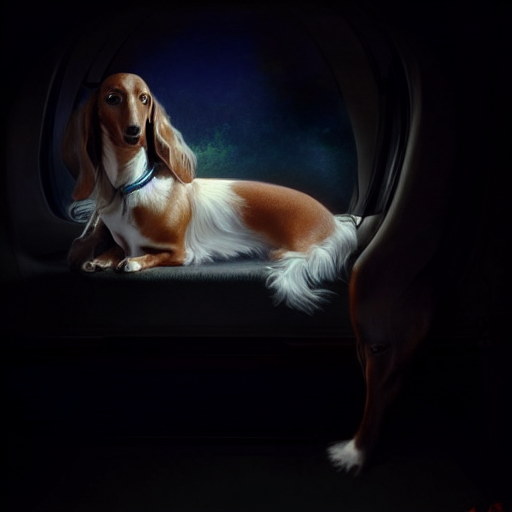

In [35]:
prompt = 'a long haired dachshund on a coach, elegant, intricate, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha'
repetitions = 5

with autocast('cuda'):
    for r in range(repetitions):
        image = model(
            prompt = prompt,
            init_image = start_image_preprocessed,
            num_inference_steps=50,
            strength = 0.8, # 0 = no noise, 1 = max noise
            guidance_scale = 7.5,# how much to rely on the textual prompt
            generator = generator,
        )
        image = image['sample'][0]
        image.show()
        image.save(f'images/{time()}_{slugify(prompt[:100])}.png')